In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from tensorflow.python.keras.utils.conv_utils import deconv_output_length

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/oskardale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oskardale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd

In [42]:
df0 = pd.read_csv('../0_data/statements.csv')
df1 = pd.read_csv('../0_data/eu_debate_transcripts_translated.csv')

In [46]:
df_chatgpt = df0[df0.provider == 'chatgpt']
df_deepseek = df0[df0.provider == 'deepseek']
documents_chatgpt = df_chatgpt.statement.values.tolist()
documents_deepseek = df_deepseek.statement.values.tolist()
documents_parliament = df1.translated_text.values.tolist()

In [48]:
stop_words = set(stopwords.words('english'))
texts_chatgpt = [[word.lower() for word in word_tokenize(doc) if word.isalpha() and word.lower() not in stop_words] for doc in documents_chatgpt]
texts_deepseek = [[word.lower() for word in word_tokenize(doc) if word.isalpha() and word.lower() not in stop_words] for doc in documents_deepseek]
texts_parliament = [[word.lower() for word in word_tokenize(doc) if word.isalpha() and word.lower() not in stop_words] for doc in documents_parliament]

In [49]:
texts = {
    'chatgpt': texts_chatgpt,
    'deepseek': texts_deepseek,
    'parliament': texts_parliament
}

In [50]:
from gensim.models import LdaModel

In [63]:
def train_lda(texts):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=4,
                         random_state=42,
                         passes=10)
    return {
        'model': lda_model,
        'dict': dictionary,
        'corpus': corpus
    }

models = {}

for name, text in texts.items():
    models[name] = train_lda(text)

In [64]:
for idx, topic in models['parliament']['model'].print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.019*"trade" + 0.015*"us" + 0.012*"european" + 0.010*"europe" + 0.009*"president" + 0.009*"tariffs" + 0.009*"must" + 0.008*"also" + 0.007*"trump" + 0.007*"united"
Topic 1: 0.011*"must" + 0.008*"trade" + 0.006*"commissioner" + 0.006*"europe" + 0.006*"us" + 0.005*"trump" + 0.004*"tariffs" + 0.004*"war" + 0.004*"president" + 0.004*"states"
Topic 2: 0.016*"trade" + 0.011*"us" + 0.010*"trump" + 0.008*"must" + 0.008*"european" + 0.008*"also" + 0.008*"eu" + 0.008*"europe" + 0.008*"president" + 0.007*"tariffs"
Topic 3: 0.013*"european" + 0.011*"trade" + 0.009*"must" + 0.009*"tariffs" + 0.007*"president" + 0.007*"union" + 0.007*"need" + 0.006*"us" + 0.006*"states" + 0.006*"one"


In [65]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=models['parliament']['model'],
                                     texts=texts_parliament,
                                     dictionary=models['parliament']['dict'],
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3765246038899912


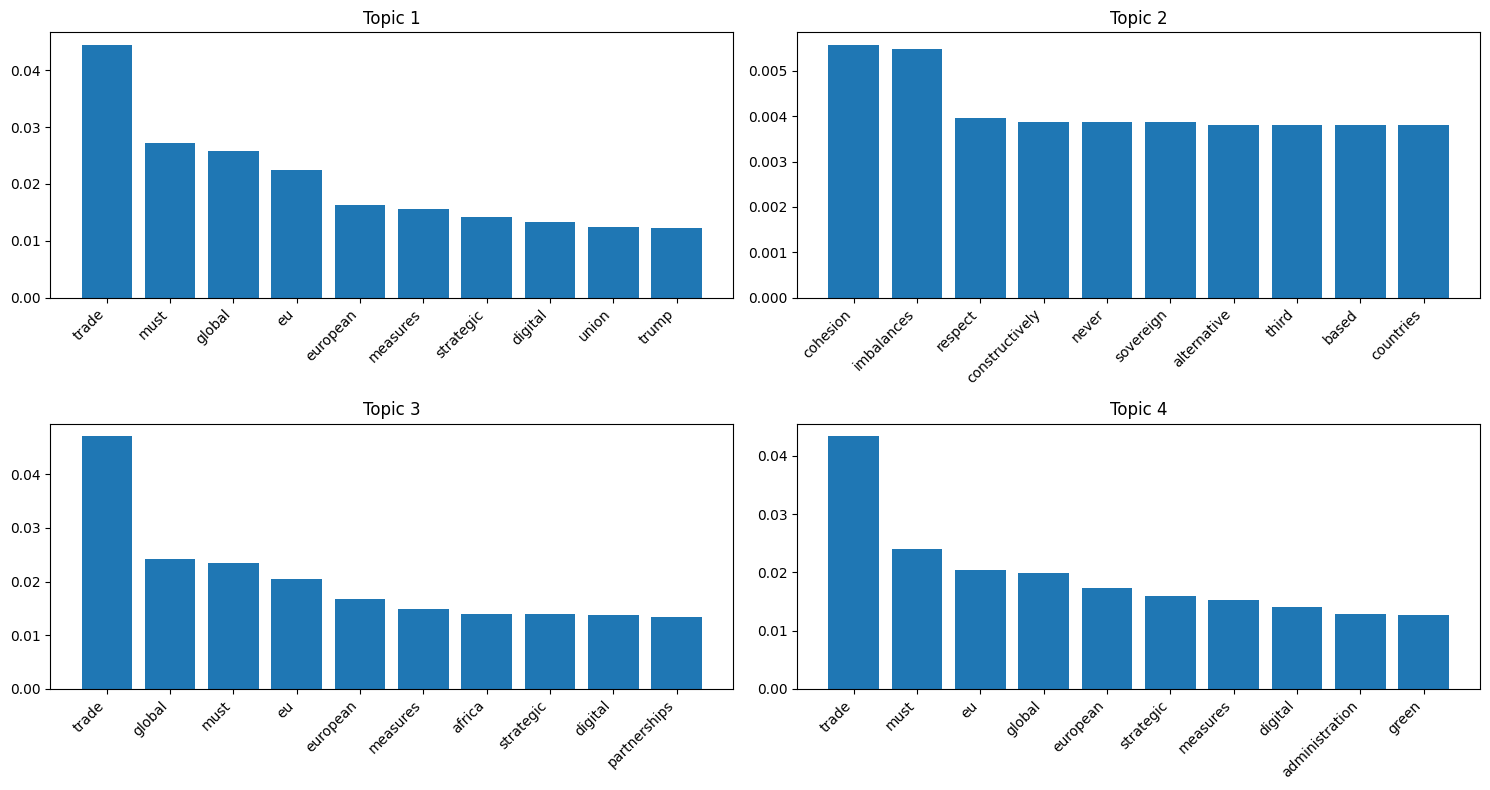

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_lda_topics(lda_model, dictionary, num_words=10):
    # Set up the plot
    fig, axes = plt.subplots(int(np.ceil(lda_model.num_topics/2)), 2,
                            figsize=(15, 4*int(np.ceil(lda_model.num_topics/2))))
    axes = axes.flatten()

    # For each topic
    for idx, topic in lda_model.show_topics(formatted=False, num_words=num_words, num_topics=-1):
        top_words = [w[0] for w in topic]
        top_probs = [w[1] for w in topic]

        # Create bar chart
        axes[idx].bar(range(num_words), top_probs)
        axes[idx].set_xticks(range(num_words))
        axes[idx].set_xticklabels(top_words, rotation=45, ha='right')
        axes[idx].set_title(f'Topic {idx+1}')

    plt.tight_layout()
    return plt

# Use the visualization
vis = visualize_lda_topics(models['deepseek']['model'], models['deepseek']['dict'])
plt.show()